In [1]:
TRAIN = 1

# SegNet model implemented with keras

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd

import sys

from skimage.io import imread
from matplotlib import pyplot as plt

import os
# os.environ['KERAS_BACKEND'] = 'theano'
# os.environ['THEANO_FLAGS'] = 'mode=FAST_RUN, device=gpu0, floatX=float32, optimizer=fast_compile'

from tensorflow.contrib.keras.python.keras import models
from tensorflow.contrib.keras.python.keras.optimizers import SGD, Adam
from tensorflow.contrib.keras.python.keras.models import model_from_json
from tensorflow.contrib.keras.python.keras.callbacks import EarlyStopping

# Build model
from tensorflow.contrib.keras.python.keras.layers.core import Activation, Reshape, Permute
from tensorflow.contrib.keras.python.keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.contrib.keras.python.keras.layers import Dropout
from tensorflow.contrib.keras.python.keras.layers.normalization import BatchNormalization

from tensorflow.contrib.keras.python.keras.utils.vis_utils import plot_model

import json

import pickle

### Data set characteristics

In [3]:
path = 'Data/'
img_w = 256
img_h = 256
n_labels = 2

n_train = 6
n_test = 3

### Utility functions

In [4]:
def label_map(labels):
    label_map = np.zeros([img_h, img_w, n_labels])    
    for r in range(img_h):
        for c in range(img_w):
            label_map[r, c, labels[r][c]] = 1
    return label_map

In [5]:
def prep_data(mode):
    assert mode in {'test', 'train'}, \
        'mode should be either \'test\' or \'train\''
    data = []
    label = []
    df = pd.read_csv(path + mode + '.csv')
    n = n_train if mode == 'train' else n_test
    for i, item in df.iterrows():
        if i >= n:
            break
        img, gt = [imread(path + item[0])], np.clip(imread(path + item[1]), 0, 1)
        data.append(img)
        label.append(label_map(gt))
        sys.stdout.write('\r')
        sys.stdout.write(mode + ": [%-20s] %d%%" % ('=' * int(20. * (i + 1) / n - 1) + '>',
                                                    int(100. * (i + 1) / n)))
        sys.stdout.flush()
    sys.stdout.write('\r')
    sys.stdout.flush()
    data, label = np.array(data).swapaxes(1, 3), np.array(label).reshape((n, img_h * img_w, n_labels))

    print(mode + ': OK')
    print('\tshapes: {}, {}'.format(data.shape, label.shape))
    print('\ttypes:  {}, {}'.format(data.dtype, label.dtype))
    print('\tmemory: {}, {} MB'.format(data.nbytes / 1048576, label.nbytes / 1048576))

    return data, label

In [6]:
def plot_results(output):
    gt = []
    df = pd.read_csv(path + 'test.csv')
    for i, item in df.iterrows():
        gt.append(np.clip(imread(path + item[1]), 0, 1))

    plt.figure(figsize=(15, 2 * n_test))
    for i, item in df.iterrows():
        plt.subplot(n_test, 5, 5 * i + 1)
        plt.title('Input Image')
        plt.axis('off')
        im = imread(path + item[0])
        plt.imshow(im, cmap='gray')
        
        plt.subplot(n_test, 5, 5 * i + 2)
        plt.title('Ground Truth')
        plt.axis('off')
        gt = imread(path + item[1])
        plt.imshow(np.clip(gt, 0, 1))

        plt.subplot(n_test, 5, 5 * i + 3)
        plt.title('Prediction')
        plt.axis('off')
        labeled = np.argmax(output[i], axis=-1)
        plt.imshow(labeled)

        plt.subplot(n_test, 5, 5 * i + 4)
        plt.title('Heat map')
        plt.axis('off')
        plt.imshow(output[i][:, :, 1])

        plt.subplot(n_test, 5, 5 * i + 5)
        plt.title('Comparison')
        plt.axis('off')
        rgb = np.empty((img_h, img_w, 3))
        rgb[:, :, 0] = labeled
        rgb[:, :, 1] = imread(path + item[0])
        rgb[:, :, 2] = gt
        plt.imshow(rgb)

    plt.savefig('result.png')
    plt.show()

### Build Model

In [7]:
img_w = 256
img_h = 256
n_labels = 2

kernel = 3

encoding_layers = [
    Conv2D(64, (kernel, kernel), padding='same', input_shape=(img_h, img_w, 1)),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(64, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),

    Conv2D(128, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(128, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),

    Conv2D(256, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(256, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(256, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),

    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),

    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(),
]

autoencoder = models.Sequential()
autoencoder.encoding_layers = encoding_layers

for l in autoencoder.encoding_layers:
    autoencoder.add(l)
    
# print(autoencoder.summary())

decoding_layers = [
    UpSampling2D(),
    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    UpSampling2D(),
    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(512, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(256, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    UpSampling2D(),
    Conv2D(256, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(256, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(128, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    UpSampling2D(),
    Conv2D(128, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(64, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),

    UpSampling2D(),
    Conv2D(64, (kernel, kernel), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(n_labels, (1, 1), padding='valid'),
    BatchNormalization(),
]
autoencoder.decoding_layers = decoding_layers
for l in autoencoder.decoding_layers:
    autoencoder.add(l)

autoencoder.add(Reshape((n_labels, img_h * img_w)))
autoencoder.add(Permute((2, 1)))
# autoencoder.add(Dropout(0.5))
autoencoder.add(Activation('softmax'))

with open('model_5l.json', 'w') as outfile:
    outfile.write(json.dumps(json.loads(autoencoder.to_json()), indent=2))

### Loading and compiling model built with *'build_model.py'*

In [8]:
# with open('model_5l.json', 'r') as f:
#     json_string = f.read()
# autoencoder = model_from_json(json_string)

optimizer = SGD(lr=0.001, momentum=0.9, decay=0.0005, nesterov=False)
# optimizer = Adam(lr=0.001, decay=0.0005)
autoencoder.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=['accuracy'])
print('Compiled: OK')

Compiled: OK


### Train model or load existing weights

In [9]:
train_data, train_label = prep_data('train')
test_data, test_label = prep_data('test')

nb_epoch = 1000
batch_size = 6

early_stopping = EarlyStopping(monitor='val_loss', verbose=1, patience=10)

history = autoencoder.fit(train_data, train_label,
                          batch_size=batch_size, epochs=nb_epoch,
                          verbose=1,
                          validation_data=(test_data, test_label),
                          shuffle=False,
                          callbacks=[early_stopping])

autoencoder.save_weights('model_5l_weight_ep50.hdf5')

train: OK==================>] 100%
	shapes: (6, 256, 256, 1), (6, 65536, 2)
	types:  uint8, float64
	memory: 0.375, 6.0 MB
test: OK==================>] 100%
	shapes: (3, 256, 256, 1), (3, 65536, 2)
	types:  uint8, float64
	memory: 0.1875, 3.0 MB
Train on 6 samples, validate on 3 samples
Epoch 1/1000
6/6 [==============================] - 12s - loss: 0.8852 - acc: 0.4921 - val_loss: 0.6932 - val_acc: 0.4772
Epoch 2/1000
6/6 [==============================] - 0s - loss: 0.8572 - acc: 0.5090 - val_loss: 0.6931 - val_acc: 0.4957
Epoch 3/1000
6/6 [==============================] - 0s - loss: 0.7967 - acc: 0.5462 - val_loss: 0.6931 - val_acc: 0.4920
Epoch 4/1000
6/6 [==============================] - 0s - loss: 0.7785 - acc: 0.5557 - val_loss: 0.6931 - val_acc: 0.5028
Epoch 5/1000
6/6 [==============================] - 0s - loss: 0.7378 - acc: 0.5815 - val_loss: 0.6931 - val_acc: 0.4856
Epoch 6/1000
6/6 [==============================] - 0s - loss: 0.6895 - acc: 0.6179 - val_loss: 0.6931 - v

6/6 [==============================] - 0s - loss: 0.1600 - acc: 0.9911 - val_loss: 0.6881 - val_acc: 0.5551
Epoch 66/1000
6/6 [==============================] - 0s - loss: 0.1582 - acc: 0.9916 - val_loss: 0.6880 - val_acc: 0.5526
Epoch 67/1000
6/6 [==============================] - 0s - loss: 0.1577 - acc: 0.9916 - val_loss: 0.6879 - val_acc: 0.5525
Epoch 68/1000
6/6 [==============================] - 0s - loss: 0.1576 - acc: 0.9915 - val_loss: 0.6877 - val_acc: 0.5548
Epoch 69/1000
6/6 [==============================] - 0s - loss: 0.1554 - acc: 0.9923 - val_loss: 0.6876 - val_acc: 0.5549
Epoch 70/1000
6/6 [==============================] - 0s - loss: 0.1563 - acc: 0.9918 - val_loss: 0.6876 - val_acc: 0.5500
Epoch 71/1000
6/6 [==============================] - 0s - loss: 0.1545 - acc: 0.9925 - val_loss: 0.6875 - val_acc: 0.5477
Epoch 72/1000
6/6 [==============================] - 0s - loss: 0.1545 - acc: 0.9924 - val_loss: 0.6874 - val_acc: 0.5473
Epoch 73/1000
6/6 [===================

6/6 [==============================] - 0s - loss: 0.1320 - acc: 0.9954 - val_loss: 0.6840 - val_acc: 0.5172
Epoch 133/1000
6/6 [==============================] - 0s - loss: 0.1331 - acc: 0.9951 - val_loss: 0.6835 - val_acc: 0.5214
Epoch 134/1000
6/6 [==============================] - 0s - loss: 0.1323 - acc: 0.9950 - val_loss: 0.6839 - val_acc: 0.5163
Epoch 135/1000
6/6 [==============================] - 0s - loss: 0.1315 - acc: 0.9955 - val_loss: 0.6844 - val_acc: 0.5085
Epoch 136/1000
6/6 [==============================] - 0s - loss: 0.1305 - acc: 0.9958 - val_loss: 0.6836 - val_acc: 0.5167
Epoch 137/1000
6/6 [==============================] - 0s - loss: 0.1303 - acc: 0.9956 - val_loss: 0.6835 - val_acc: 0.5161
Epoch 138/1000
6/6 [==============================] - 0s - loss: 0.1285 - acc: 0.9963 - val_loss: 0.6842 - val_acc: 0.5079
Epoch 139/1000
6/6 [==============================] - 0s - loss: 0.1304 - acc: 0.9957 - val_loss: 0.6838 - val_acc: 0.5097
Epoch 140/1000
6/6 [===========

In [10]:
# plt.imshow(train_data[0, :, :, 0], cmap='gray')
# plt.show()

In [11]:
# autoencoder.load_weights('model_5l_weight_ep50.hdf5')

### Model visualization

In [12]:
plot_model(autoencoder, to_file='model.png', show_shapes=True)

### Load testing data and evaluate score

In [13]:
test_data, test_label = prep_data('test')
score = autoencoder.evaluate(test_data, test_label, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

train_data, train_label = prep_data('train')
score = autoencoder.evaluate(train_data, train_label, verbose=0)
print('Train score:', score[0])
print('Train accuracy:', score[1])

test: OK==================>] 100%
	shapes: (3, 256, 256, 1), (3, 65536, 2)
	types:  uint8, float64
	memory: 0.1875, 3.0 MB
Test score: 0.683879613876
Test accuracy: 0.503906369209
train: OK==================>] 100%
	shapes: (6, 256, 256, 1), (6, 65536, 2)
	types:  uint8, float64
	memory: 0.375, 6.0 MB
Train score: 0.683230280876
Train accuracy: 0.512532651424


### Visualizing results

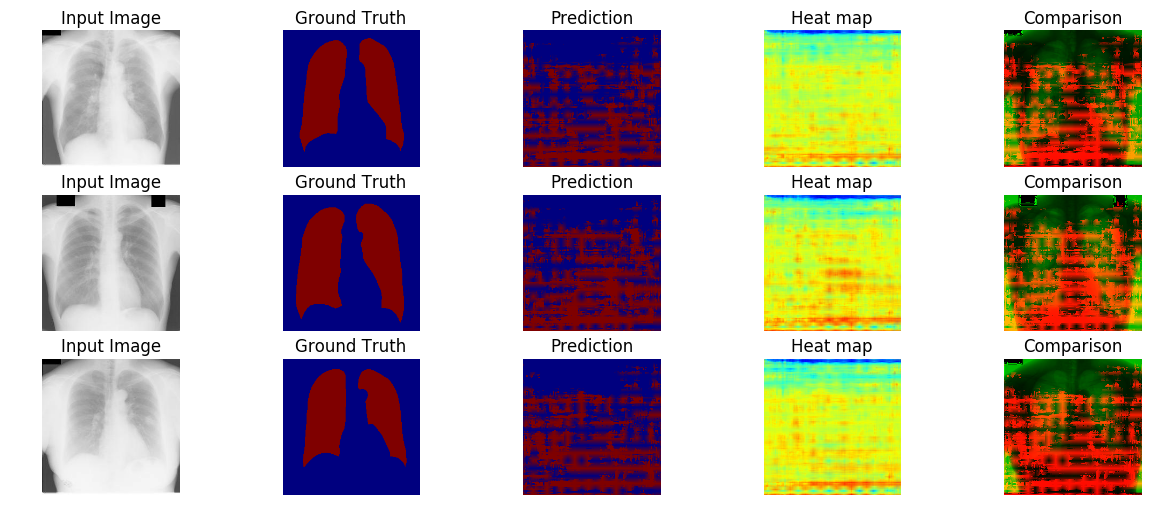

In [14]:
output = autoencoder.predict_proba(test_data, verbose=0)
# output = autoencoder.predict_proba(train_data, verbose=0)
output = output.reshape((output.shape[0], img_h, img_w, n_labels))

plot_results(output)

dict_keys(['acc', 'val_loss', 'val_acc', 'loss'])


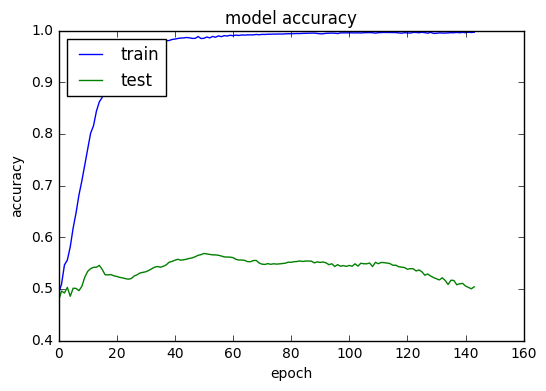

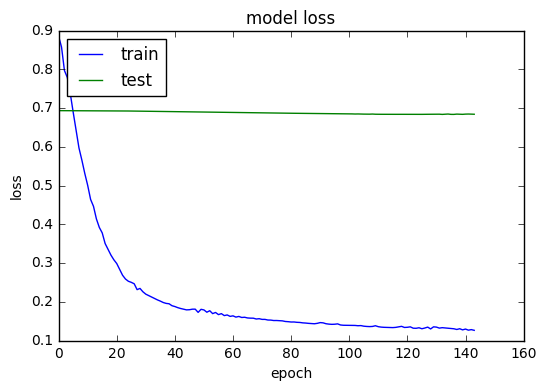

In [15]:
with open('training_his.pickle', 'wb') as f:
    pickle.dump(history.history, f)
history_ = history.history

# list all data in history
print(history_.keys())
# summarize history for accuracy
plt.plot(history_['acc'])
plt.plot(history_['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_['loss'])
plt.plot(history_['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()